In [1]:
#Required packages
import os
os.environ["PROJ_LIB"] = r'C:\Users\uqjojeda\Anaconda3\Library\share'; #fixr
from netCDF4 import Dataset
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import matplotlib.ticker as ticker
import glob
import geopandas as gpd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [52]:
#Read and merge all nc files from psims (if more than a file in a folder write *.nc4 at the end of the address)
climate2 = xr.open_mfdataset(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\climateData\*.nc4')

In [53]:
#Create new coordinates in the xarray
climate3 = climate2.assign(jday=lambda x: climate2.time.dt.dayofyear)
climate4 = climate3.assign(year=lambda x: climate3.time.dt.year)
climate5 = climate4.assign(rain=lambda x: climate4.pr *86400)
climate6 = climate5.assign(radn=lambda x: climate5.rsds *24*60*60 /1000000)
climate7 = climate6.assign(tmax=lambda x: climate6.tasmax - 273.15)
climate8 = climate7.assign(tmin=lambda x: climate7.tasmin - 273.15)
climate = climate8.assign(tmean=lambda x: ((climate8.tasmax- 273.15) + (climate8.tasmin- 273.15))/ 2)

In [313]:
climate

,Array,Chunk
Bytes,169.57 MB,724.67 kB
Shape,"(11323, 52, 72)","(11323, 4, 4)"
Count,1857 Tasks,234 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,169.57 MB,724.67 kB
Shape,"(11323, 52, 72)","(11323, 4, 4)"
Count,1857 Tasks,234 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [54]:
#Conver multidimendional frame to 2D frame
clim = climate.to_dataframe()
clim2 = clim.reset_index()
env = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\KMEANS.csv')
df = env.merge(clim2, how='inner', on=['lat','lon'])
df2 = df.drop(['rad40DAS', 'rad80DAS', 'radHarv', 'rain40DAS',
       'rain80DAS', 'rainHarv', 'temp40DAS', 'temp80DAS', 'tempHarv',
       'biomass', 'env'], axis=1)

In [303]:
#Remove first and last months of the dataset
df3 = df2.loc[(df2['time'] > '1980-06-30 01:00:00') & (df2['time'] < '2010-07-01 01:00:00')]
df3['ID'] = df3.groupby(df3.jday.shift().eq(183).cumsum()).cumcount()

<ipython-input-303-e50581229107>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['ID'] = df3.groupby(df3.jday.shift().eq(183).cumsum()).cumcount()


In [302]:
#Filter data with MeanTem < 11 degrees
pdate1 = df3.groupby(['lat', 'lon','ID'],as_index=False).mean()
pdate2 = pdate1.loc[pdate1['tmean'] <= 11]
pdate3 = pdate2.groupby(['lat','lon'],as_index=True).max('ID')
#Arrange dataframes
pdate4 = pdate3.loc[pdate3['ID'] < 183]
pdate5 = pdate4.drop(['jday'], axis=1)
pdate5['jday'] = pdate5['ID'] + 183
pdate6 = pdate3.loc[pdate3['ID'] >= 183]
pdate7 = pdate6.drop(['jday'], axis=1)
pdate7['jday'] = pdate7['ID'] - 183
pdate8 = pd.concat([pdate5,pdate7])

In [324]:
#Check reduction in cropland taking out some specific percentage of non covered grids
cropland0 = pdate8.loc[pdate8['cropland'] > 0] #1285/1765*100
print(1285/1765*100)
cropland10 = pdate8.loc[pdate8['cropland'] > 10] #1046/1765*100
print(1046/1765*100)
cropland20 = pdate8.loc[pdate8['cropland'] > 20] #905/1765*100
print(905/1765*100)
cropland20.shape

72.80453257790369
59.26345609065156
51.27478753541076


(905, 16)

In [ ]:
#Create xarray
pdate9 = pdate8.loc[pdate8['jday'] < 300]
pdate10 = pdate9.reset_index()
pdate11 = pdate10.drop_duplicates(['lat','lon'], keep= 'first')
pdate12 = pdate11.set_index(['lon','lat'])
pdate = pdate12.to_xarray()

In [305]:
#Filter data with MeanTem < 11 degrees
frost1 = df3.groupby(['lat', 'lon','ID'],as_index=False).mean()
frost2 = frost1.loc[frost1['tmin'] <= 0]
frost3 = frost2.groupby(['lat','lon'],as_index=True).max('ID')
#Arrange dataframes
frost4 = frost3.loc[frost3['ID'] < 183]
frost5 = frost4.drop(['jday'], axis=1)
frost5['jday'] = frost5['ID'] + 183
frost6 = frost3.loc[frost3['ID'] >= 183]
frost7 = frost6.drop(['jday'], axis=1)
frost7['jday'] = frost7['ID'] - 183
frost8 = pd.concat([frost5,frost7])

In [306]:
#Create xarray
frost9 = frost8.loc[frost8['jday'] < 300]
frost10 = frost9.reset_index()
frost11 = frost10.drop_duplicates(['lat','lon'], keep= 'first')
frost12 = frost11.set_index(['lon','lat'])
frost = frost12.to_xarray()

In [26]:
dfsum2 = df2.groupby(['lat', 'lon','year'],as_index=False).sum()
dfsum = dfsum2.drop(['tmax','tmin','tmean','jday','tasmax','tasmin','rsds','pr'], axis=1)
dfsum.set_index(['lat', 'lon', 'year'], inplace=True)
data = dfsum.to_xarray()

dfmean2 = df2.groupby(['lat', 'lon','year'],as_index=False).mean()
dfmean = dfmean2.drop(['jday','tasmax','tasmin','rsds','pr','rain','radn'], axis=1)
dfmean.set_index(['lat', 'lon', 'year'], inplace=True)
data2 = dfmean.to_xarray()

In [27]:
#Create dataframes for Apr-Jun, Jul-Ag, Sept-Oct
dfA = df2[(df2['jday'] >= 91) & (df2['jday'] <= 161)]
dfA['period'] = '1st (91-161DOY)'
dfB = df2[(df2['jday'] >= 162) & (df2['jday'] <= 232)]
dfB['period'] = '2nd (162-232DOY)'
dfC = df2[(df2['jday'] >= 233) & (df2['jday'] <= 304)]
dfC['period'] = '3rd (233-304DOY)'
frames = [dfA, dfB, dfC]
result = pd.concat(frames)

#Calculate the sum dataframe
dfsum2 = result.groupby(['lat', 'lon','year','period'],as_index=False).sum()
dfsum1 = dfsum2.drop(['tmax','tmin','tmean','cropland','jday','tasmax','tasmin','rsds','wind','hur','hurtmax','pr'], axis=1)
dfsum1.set_index(['lat', 'lon', 'year','period'], inplace=True)
dfsum = dfsum1.to_xarray()

#Calculate the mean dataframe
dfmean2 = result.groupby(['lat', 'lon','year','period'],as_index=False).mean()
dfmean1 = dfmean2.drop(['jday','tasmax','tasmin','rsds','pr','rain','radn'], axis=1)
dfmean1.set_index(['lat', 'lon', 'year','period'], inplace=True)
dfmean = dfmean1.to_xarray()

<ipython-input-27-3aac3c9bd5d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfA['period'] = '1st (91-161DOY)'
<ipython-input-27-3aac3c9bd5d0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfB['period'] = '2nd (162-232DOY)'
<ipython-input-27-3aac3c9bd5d0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [41]:
#Convert to dataframe and merge variables

df0 = dfA.groupby(['lat', 'lon','year'],as_index=False).sum()
dfa = df0.drop(['tmax','tmin','tmean','cropland','jday','tasmax','tasmin','rsds','wind','hur','hurtmax','pr'], axis=1)

df1 = dfB.groupby(['lat', 'lon','year'],as_index=False).sum()
dfb = df1.drop(['tmax','tmin','tmean','cropland','jday','tasmax','tasmin','rsds','wind','hur','hurtmax','pr'], axis=1)

df2 = dfC.groupby(['lat', 'lon','year'],as_index=False).sum()
dfc = df2.drop(['tmax','tmin','tmean','cropland','jday','tasmax','tasmin','rsds','wind','hur','hurtmax','pr'], axis=1)
dfc.rename(columns={'rain':'rain_c','radn':'radn_c'}, inplace=True)

df3 = dfA.groupby(['lat', 'lon','year'],as_index=False).mean()
dfa2 = df3.drop(['jday','tasmax','tasmin','rsds','pr','rain','radn'], axis=1)

df4 = dfB.groupby(['lat', 'lon','year'],as_index=False).mean()
dfb2 = df4.drop(['jday','tasmax','tasmin','rsds','pr','rain','radn'], axis=1)

df5 = dfC.groupby(['lat', 'lon','year'],as_index=False).mean()
dfc2 = df5.drop(['jday','tasmax','tasmin','rsds','pr','rain','radn'], axis=1)
dfc2.rename(columns={'tmin':'tmin_c','tmax':'tmax_c','tmean':'tmean_c','wind':'wind_c','hur':'hur_c','hurtmax':'hurtmax_c','cropland':'cropland_c'}, inplace=True)

alldata2 = pd.merge(dfa, dfb, how ='inner', on =['lat','lon','year'], suffixes=("_a", "_b"))
alldata3 = pd.merge(alldata2, dfc, how ='inner', on =['lat','lon','year'])
alldata4 = pd.merge(dfa2, dfb2, how ='inner', on =['lat','lon','year'], suffixes=("_a", "_b"))
alldata5 = pd.merge(alldata4, dfc2, how ='inner', on =['lat','lon','year'])
alldata6 = pd.merge(alldata3, alldata5, how ='inner', on =['lat','lon','year'])

alldata = alldata6.groupby(['lat', 'lon'],as_index=False).mean()

alldata['radn'] = alldata['radn_a'] + alldata['radn_b'] + alldata['radn_c']
alldata['rain'] = alldata['rain_a'] + alldata['rain_b'] + alldata['rain_c']
alldata['tmin'] = (alldata['tmin_a'] + alldata['tmin_b'] + alldata['tmin_c'])/3
alldata['tmax'] = (alldata['tmax_a'] + alldata['tmax_b'] + alldata['tmax_c'])/3
alldata['tmean'] = (alldata['tmean_a'] + alldata['tmean_b'] + alldata['tmean_c'])/3
alldata['wind'] = (alldata['wind_a'] + alldata['wind_b'] + alldata['wind_c'])/3
alldata['hur'] = (alldata['hur_a'] + alldata['hur_b'] + alldata['hur_c'])/3
alldata['hurtmax'] = (alldata['hurtmax_a'] + alldata['hurtmax_b'] + alldata['hurtmax_c'])/3
alldata['cropland'] = (alldata['cropland_a'] + alldata['cropland_b'] + alldata['cropland_c'])/3
alldata1 = alldata.drop(['year'], axis=1)

#Send data to calculate clusters
#alldata1.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\newenv.csv')

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-12-96edf07616d6>:75: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


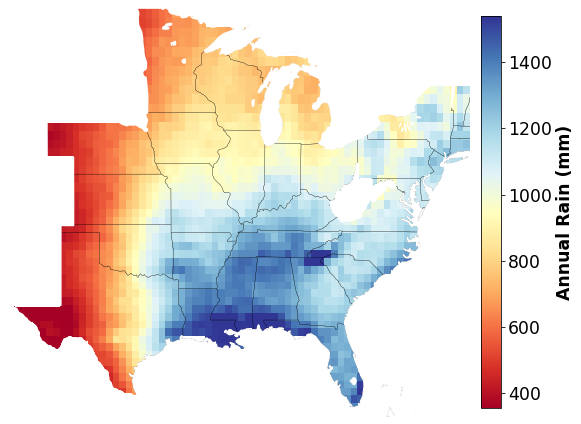

In [12]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=data.rain.mean(dim=('year'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdYlBu, add_colorbar=False, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Annual Rain (mm)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\elevation.png', dpi=600, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-14-a270379ffece>:75: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


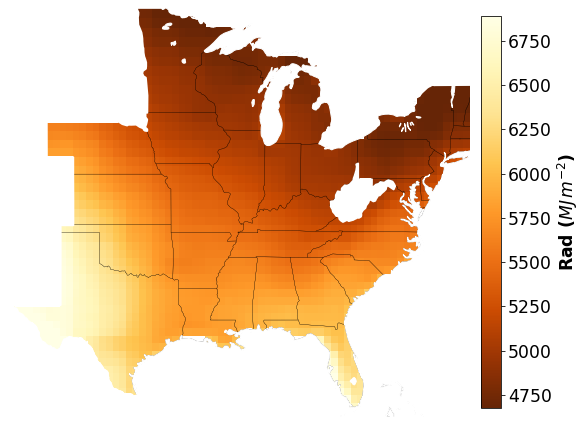

In [14]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=data.radn.mean(dim=('year'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.YlOrBr_r, add_colorbar=False, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Rad ($MJ\,m^{-2}$)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\elevation.png', dpi=600, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-19-e0368ea2ec0e>:75: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


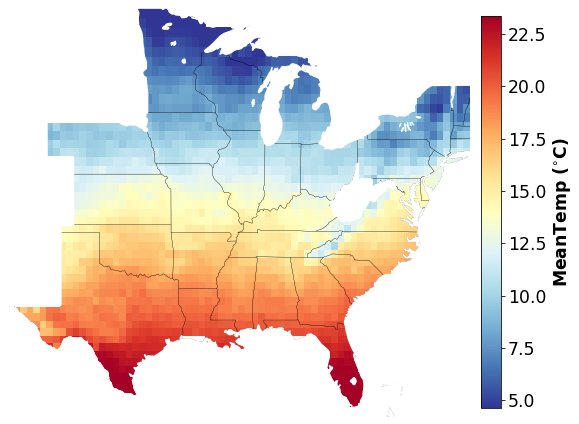

In [19]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=data2.tmean.mean(dim=('year'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdYlBu_r, add_colorbar=False, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='MeanTemp ($^{\circ}$C)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\elevation.png', dpi=600, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-43-ce7b74bee057>:72: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


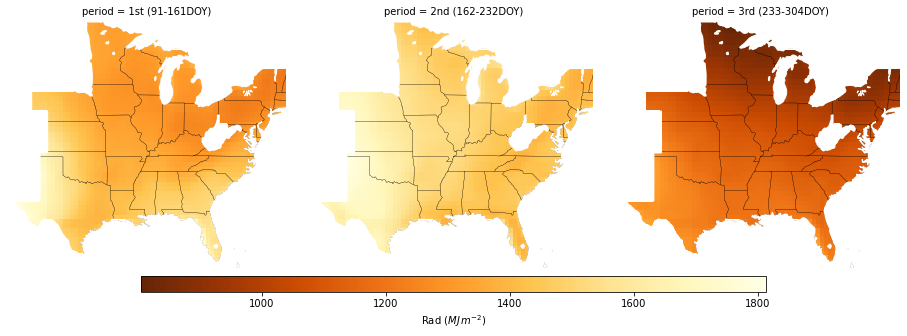

In [43]:
map_proj = ccrs.Mercator(central_longitude=-95)

p = dfsum.radn.mean(dim=('year'), skipna=True).plot(x='lon', y='lat', col='period',col_wrap=3,
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, #=a.biomass2.min(),vmax=a.biomass2.max(),
    figsize=(16,8),
    cmap=mpl.cm.YlOrBr_r,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

# #Edit title of columns and rows
# axes = p.axes.flatten()
# axes[0].set_title("GS", fontsize=18, fontweight="bold")
# axes[1].set_title("SS", fontsize=18, fontweight="bold")
# axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
# axes[3].set_title("FS", fontsize=18, fontweight="bold")

# irri_labels =  ["","","","Rainfed","","","","Irrigated"]

# for i, ax in enumerate(p.axes.flat):
#     plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.1, hspace=0.15)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Rad ($MJ\,m^{-2}$)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\mean_biomass.png', dpi=600, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-45-c95a30e3420c>:72: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


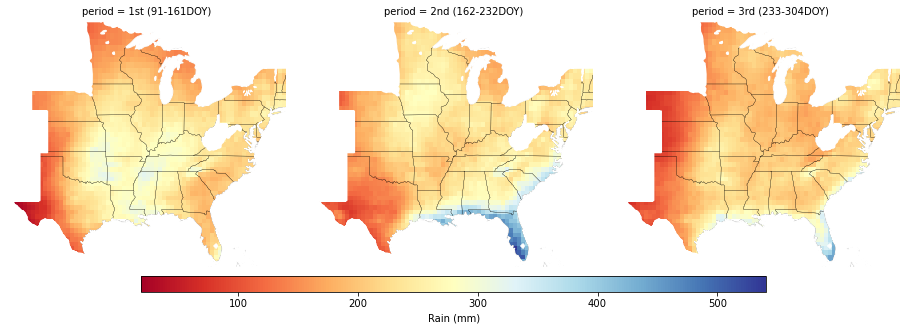

In [45]:
map_proj = ccrs.Mercator(central_longitude=-95)

p = dfsum.rain.mean(dim=('year'), skipna=True).plot(x='lon', y='lat', col='period',col_wrap=3,
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, #=a.biomass2.min(),vmax=a.biomass2.max(),
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

# #Edit title of columns and rows
# axes = p.axes.flatten()
# axes[0].set_title("GS", fontsize=18, fontweight="bold")
# axes[1].set_title("SS", fontsize=18, fontweight="bold")
# axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
# axes[3].set_title("FS", fontsize=18, fontweight="bold")

# irri_labels =  ["","","","Rainfed","","","","Irrigated"]

# for i, ax in enumerate(p.axes.flat):
#     plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.1, hspace=0.15)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Rain (mm)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\mean_biomass.png', dpi=600, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-42-826701452a39>:72: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


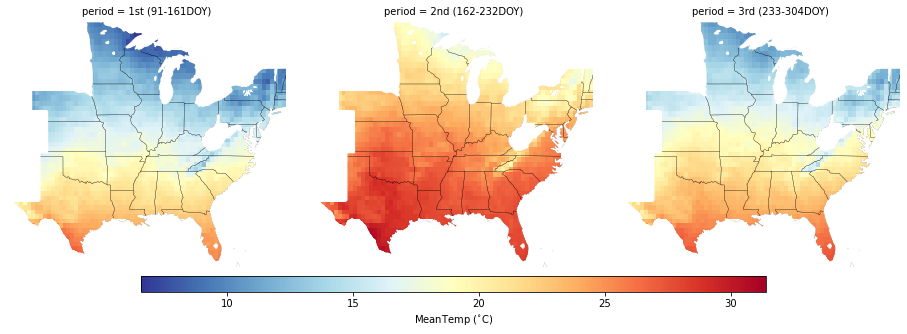

In [42]:
map_proj = ccrs.Mercator(central_longitude=-95)

p = dfmean.tmean.mean(dim=('year'), skipna=True).plot(x='lon', y='lat', col='period',col_wrap=3,
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, #=a.biomass2.min(),vmax=a.biomass2.max(),
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu_r,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

# #Edit title of columns and rows
# axes = p.axes.flatten()
# axes[0].set_title("GS", fontsize=18, fontweight="bold")
# axes[1].set_title("SS", fontsize=18, fontweight="bold")
# axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
# axes[3].set_title("FS", fontsize=18, fontweight="bold")

# irri_labels =  ["","","","Rainfed","","","","Irrigated"]

# for i, ax in enumerate(p.axes.flat):
#     plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.1, hspace=0.15)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='MeanTemp ($^{\circ}$C)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\mean_biomass.png', dpi=600, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-304-7019daece78b>:75: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


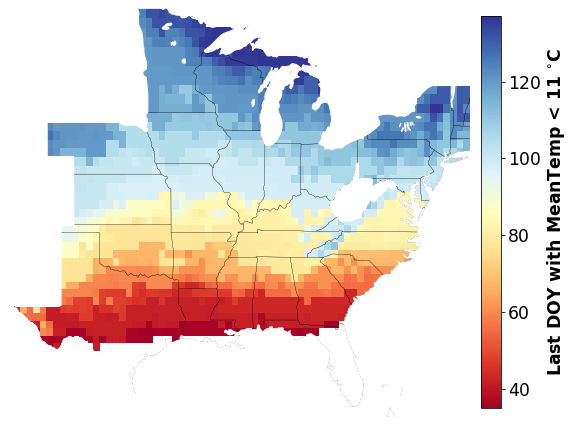

In [304]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=pdate.jday.plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdYlBu, add_colorbar=False, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Last DOY with MeanTemp < 11 $^{\circ}$C', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\temp11.png', dpi=600, bbox_inches='tight', pad_inches=0)

<ipython-input-312-fcad27201046>:75: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


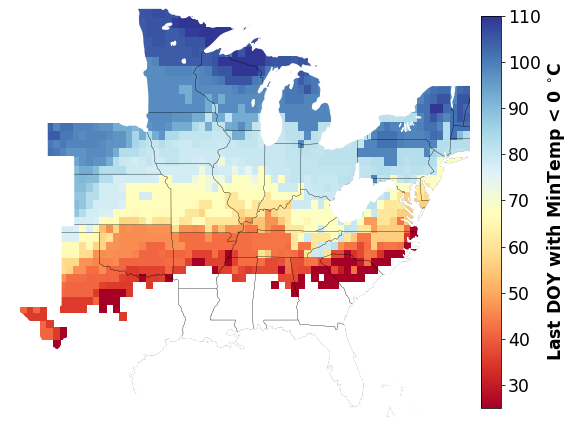

In [312]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=frost.jday.plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdYlBu, add_colorbar=False, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Last DOY with MinTemp < 0 $^{\circ}$C', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\temp0.png', dpi=600, bbox_inches='tight', pad_inches=0)